In [ ]:
pip install --upgrade xgboost

In [ ]:
import xgboost as xgb
print(xgb.__version__)

2.1.3


In [ ]:
# Import thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Tải dữ liệu từ Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
df = pd.read_csv('/content/gdrive/MyDrive/Khóa luân 2024 (Nguyễn Tiến Anh QUân)/Dữ liệu/HCM.csv')
# Chuyển đổi cột "Ngày" sang dạng datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Sắp xếp dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Date')

# Chuyển đổi định dạng các cột giá thành số thực
df['Closing Price'] = df['Closing Price'].replace(',', '').astype(float)
df['Opening Price'] = df['Opening Price'].replace(',', '').astype(float)
df['Highest Price'] = df['Highest Price'].replace(',', '').astype(float)
df['Lowest Price'] = df['Lowest Price'].replace(',', '').astype(float)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Tạo dataframe đơn giản chỉ chứa "Date" và "Closing Price"
df11 = pd.DataFrame(df, columns=['Date', 'Closing Price'])
df11.index = df11.Date
df11.drop('Date', axis=1, inplace=True)

# Chuyển dữ liệu thành dạng mảng numpy
data = df11.values

In [ ]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [ ]:
# Tạo dữ liệu đầu vào và đầu ra cho mô hình
x_train, y_train = [], []
window_size = 50
for i in range(window_size, len(data)):
    x_train.append(sc_train[i-window_size:i, 0])
    y_train.append(sc_train[i, 0])

x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
# K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
best_model_file = "/content/gdrive/MyDrive/Khóa luân 2024 (Nguyễn Tiến Anh QUân)/allsavemodel/savemodelxgboost/xgboost_model_kfold.keras"

fold = 1
mae_scores, mse_scores, r2_scores = [], [], []
best_mae = float("inf")
best_model = None

for train_index, val_index in kfold.split(x_train):
    print(f"\n=== Huấn luyện Fold {fold} ===")

    # Chia dữ liệu thành tập train và validation
    x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Chuyển dữ liệu thành DMatrix
    dtrain = xgb.DMatrix(x_train_fold, label=y_train_fold)
    dval = xgb.DMatrix(x_val_fold, label=y_val_fold)

    # Thiết lập tham số
    params = {
        "objective": "reg:squarederror",
        "learning_rate": 0.01,
        "max_depth": 5,
        "seed": 42
    }

    # Huấn luyện với early stopping
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dval, "validation")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Dự đoán trên tập validation
    y_val_predict = bst.predict(dval)
    y_val_predict = sc.inverse_transform(y_val_predict.reshape(-1, 1))
    y_val_actual = sc.inverse_transform(y_val_fold.reshape(-1, 1))

    # Đánh giá mô hình
    mae = mean_absolute_error(y_val_actual, y_val_predict)
    mse = mean_squared_error(y_val_actual, y_val_predict)
    r2 = r2_score(y_val_actual, y_val_predict)

    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"Fold {fold} - MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")
    # Lưu mô hình tốt nhất dựa trên MAE
    if mae < best_mae:
        best_mae = mae
        best_model = bst
        bst.save_model(best_model_file)
        print(f"Mô hình tốt nhất được lưu vào: {best_model_file}")

    fold += 1



=== Huấn luyện Fold 1 ===
Fold 1 - MAE: 0.7481, MSE: 1.2226, R²: 0.9926


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Mô hình tốt nhất được lưu vào: /content/gdrive/MyDrive/Khóa luân 2024 (Nguyễn Tiến Anh QUân)/allsavemodel/savemodelxgboost/xgboost_model_kfold.keras

=== Huấn luyện Fold 2 ===
Fold 2 - MAE: 0.6778, MSE: 0.9786, R²: 0.9943
Mô hình tốt nhất được lưu vào: /content/gdrive/MyDrive/Khóa luân 2024 (Nguyễn Tiến Anh QUân)/allsavemodel/savemodelxgboost/xgboost_model_kfold.keras

=== Huấn luyện Fold 3 ===


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:40:19] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Fold 3 - MAE: 0.8830, MSE: 2.7918, R²: 0.9857

=== Huấn luyện Fold 4 ===
Fold 4 - MAE: 0.7719, MSE: 1.4485, R²: 0.9917

=== Huấn luyện Fold 5 ===
Fold 5 - MAE: 0.7543, MSE: 1.4609, R²: 0.9903


In [ ]:
# Kết quả trung bình của các fold
print("\n=== Kết quả trung bình qua các fold ===")
print(f"MAE trung bình: {np.mean(mae_scores):.4f}")
print(f"MSE trung bình: {np.mean(mse_scores):.4f}")
print(f"R² trung bình: {np.mean(r2_scores):.4f}")



=== Kết quả trung bình qua các fold ===
MAE trung bình: 0.7670
MSE trung bình: 1.5805
R² trung bình: 0.9909



Tải mô hình tốt nhất từ file: /content/gdrive/MyDrive/Khóa luân 2024 (Nguyễn Tiến Anh QUân)/allsavemodel/savemodelxgboost/xgboost_model_kfold.keras


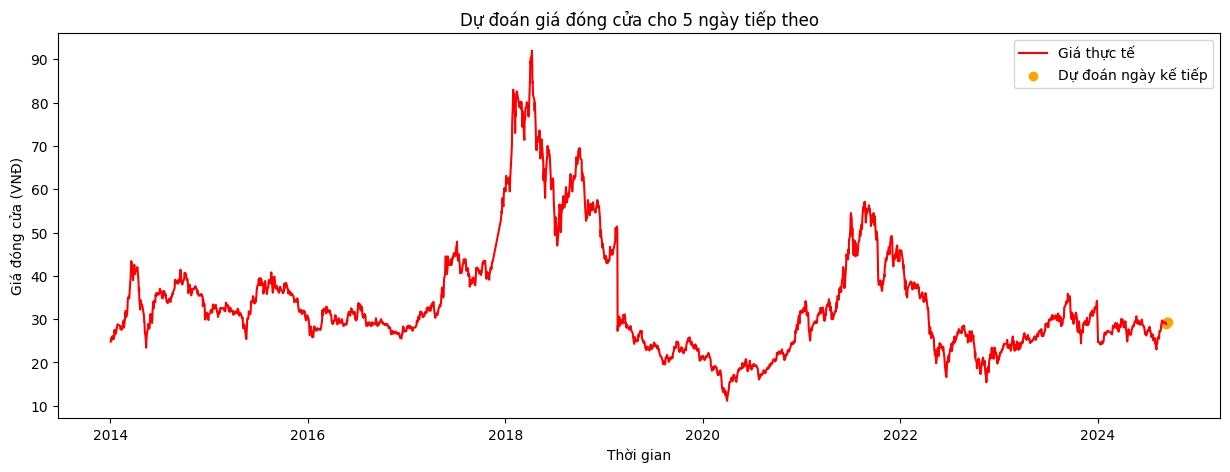


Dự đoán giá cho 5 ngày tiếp theo:
        Date  Predict Price
0 2024-09-11      28.960358
1 2024-09-12      29.018164
2 2024-09-13      29.227278
3 2024-09-14      29.367619
4 2024-09-15      29.374680


In [ ]:
# Tải lại mô hình tốt nhất
bst = xgb.Booster()
bst.load_model(best_model_file)
print(f"\nTải mô hình tốt nhất từ file: {best_model_file}")

# Dự đoán cho 5 ngày tiếp theo
next_date = df['Date'].iloc[-1]
predictions = []
dates = []

for i in range(5):
    # Lấy 50 giá trị gần nhất
    x_next = sc_train[-window_size:, 0].reshape(1, -1)
    dnext = xgb.DMatrix(x_next)
    y_next_predict = bst.predict(dnext)
    y_next_predict = sc.inverse_transform(y_next_predict.reshape(-1, 1))
    predictions.append(y_next_predict[0][0])

    # Thêm giá trị dự đoán vào dữ liệu
    sc_train = np.append(sc_train, sc.transform(y_next_predict), axis=0)

    # Tăng ngày
    next_date = next_date + pd.Timedelta(days=1)
    dates.append(next_date)

# Tạo DataFrame dự đoán
df_next = pd.DataFrame({'Date': dates, 'Closing Price': predictions})
df1 = pd.concat([df11, df_next])

# Vẽ biểu đồ
plt.figure(figsize=(15, 5))
plt.plot(df['Date'], df['Closing Price'], label='Giá thực tế', color='red')
plt.scatter(dates, predictions, color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('Dự đoán giá đóng cửa cho 5 ngày tiếp theo')
plt.legend()
plt.show()

# In bảng so sánh
comparison_df = pd.DataFrame({'Date': dates, 'Predict Price': predictions})
print("\nDự đoán giá cho 5 ngày tiếp theo:")
print(comparison_df)